<a href="https://colab.research.google.com/github/nicoelbert/deepflash2/blob/master/nbs/tutorial_train_and_pred_3channel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# deepflash2 - Train and Predict Tutorial
This notebook is optmizied to be executed on Google Colab (https://colab.research.google.com). It reproduces the results of the deepflash2 [paper](https://arxiv.org/abs/2111.06693) for semantic and instance segmentation.


*   Please read the instructions carefully.
*   Press the the *play* butten to execute the cells. It will show up between \[     \] on the left side of the code cells. 
*   Run the cells consecutively.

*References*:

Griebel, M., Segebarth, D., Stein, N., Schukraft, N., Tovote, P., Blum, R., & Flath, C. M. (2021). Deep-learning in the bioimaging wild: Handling ambiguous data with deepflash2. arXiv preprint arXiv:2111.06693.

>[deepflash2 - Train and Predict Tutorial](#scrollTo=RxDLprsbAwFB)

>>[Setup](#scrollTo=QdQqu0uiAwFB)

>>>[Settings](#scrollTo=5e3H5-UVAwFC)

>>>[Example Data](#scrollTo=D-tcpoRgAwFE)

>>>[Own Data](#scrollTo=feB973ZuAwFM)

>>>>[Google Drive & local](#scrollTo=Y5lfcip6AwFM)

>>>>[.zip file](#scrollTo=l1GU6IUHAwFM)

>>>[Data preprocessing](#scrollTo=VHmM_VSTAwFN)

>>[Train models](#scrollTo=8_GWdJM_AwFN)

>>[Prediction on test set](#scrollTo=kI3khgKLAwFN)



## Setup
In this section, you will set up the training environment, install all dependencies and connect to the drive with the prepared datasets.

In [ ]:
!pip install deepflash2 --q
!pip install utils --q

# Imports
import numpy as np
from deepflash2.all import *
from pathlib import Path
import imageio
import shutil

     |████████████████████████████████| 56 kB 2.7 MB/s 
     |████████████████████████████████| 153 kB 25.8 MB/s 
     |████████████████████████████████| 88 kB 5.8 MB/s 
     |████████████████████████████████| 197 kB 46.1 MB/s 
     |████████████████████████████████| 3.3 MB 49.8 MB/s 
     |████████████████████████████████| 102 kB 56.1 MB/s 
     |████████████████████████████████| 47.6 MB 1.4 MB/s 
     |████████████████████████████████| 59 kB 6.4 MB/s 
     |████████████████████████████████| 34.5 MB 1.2 MB/s 
     |████████████████████████████████| 58 kB 6.7 MB/s 
     |████████████████████████████████| 376 kB 64.9 MB/s 
     |████████████████████████████████| 6.2 MB 18.9 MB/s 


### Settings



Prior to Training the dataset needs to be selected. If you don't run the notebook in Colab, the `OUTPUT_PATH`and `MODEL_PATH` need to be adjusted to point on existing directorys.

In [ ]:
# Connect to drive
try:
  from google.colab import drive
  drive.mount('/gdrive')
except:
  print('Google Drive is not available.')

SEED = 0 # We used seeds [0,1,2] in our experiemnts
OUTPUT_PATH = Path("/content/predictions") # Save predictions here
MODEL_PATH = Path("/content/models") # Save models here
TRAINED_MODEL_PATH= Path('/gdrive/MyDrive/deepflash2-paper/models/')

# deepflash2 config class
cfg = Config(random_state=SEED,
             instance_labels=True)

Mounted at /gdrive


In [ ]:
####-> move into functions
def download_file(url, save_path):
    local_filename = save_path
    # NOTE the stream=True parameter below
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)

    return local_filename

def save_mask_int16(mask, path, filetype='.png'):
    mask = mask.astype(np.uint16) if np.max(mask)>1 else (mask*656535).astype(np.uint16)
    imageio.imsave(path.with_suffix(filetype), mask)

In [ ]:
import requests
import zipfile

url = 'https://drive.google.com/u/0/uc?id=1NKkSQ5T0ZNQ8aUhh0a8Dt2YKYCQXIViw&export=download&confirm=t'
!mkdir 'MoNuSegTestData'
download_file(url,'MoNuSegTestData/MoNuSegTestData.zip')

#download
with zipfile.ZipFile('MoNuSegTestData/MoNuSegTestData.zip',"r") as zip_ref:
            zip_ref.extractall('MoNuSegTestData')

In [ ]:
DATASET = 'MoNuSegTestData'
DATA_PATH = Path('./')


test_data_path = Path('MoNuSegTestData/MoNuSegTestData/')
save_path = Path('MoNuSegTestData/masks/')
png_path = Path('MoNuSegTestData/masks_imgs/')
!mkdir 'MoNuSegTestData/masks/'
!mkdir 'MoNuSegTestData/masks_imgs/'

mkdir: cannot create directory ‘MoNuSegTestData/masks/’: File exists
mkdir: cannot create directory ‘MoNuSegTestData/masks_imgs/’: File exists


In [ ]:
#https://drive.google.com/file/d/1NKkSQ5T0ZNQ8aUhh0a8Dt2YKYCQXIViw/view

In [ ]:

#https://github.com/vqdang/hover_net/blob/d743e633ed59e588af6113cae185d4db589b4368/src/misc/proc_kumar_ann.py#L39
##
## For processing .xml annotation file in Kumar dataset
##

import glob
import os
import xml.etree.ElementTree as ET

import cv2
import numpy as np

#from utils import rm_n_mkdir

###
imgs_dir = test_data_path#"" # .tif 
anns_dir = test_data_path#"" # .xml folders
save_dir = save_path #"" # storing .npy ground truth (HW)

file_list = glob.glob(str(test_data_path / '*.tif'))
file_list.sort() # ensure same order [1]

#rm_n_mkdir(save_dir)

for filename in file_list: # png for base
    filename = os.path.basename(filename)
    basename = filename.split('.')[0]

    print(basename)
    img = cv2.imread(str(imgs_dir / filename))
    print(str(imgs_dir / filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    hw = img.shape[:2]

    xml = ET.parse(anns_dir / str(basename + '.xml'))

    contour_dbg = np.zeros(hw, np.uint8)

    insts_list = []
    for idx, region_xml in enumerate(xml.findall('.//Region')):
        vertices = []
        for vertex_xml in region_xml.findall('.//Vertex'):
            attrib = vertex_xml.attrib
            vertices.append([float(attrib['X']), 
                            float(attrib['Y'])])
        vertices = np.array(vertices) + 0.5
        vertices = vertices.astype('int32')
        contour_blb = np.zeros(hw, np.uint8)
        # fill both the inner area and contour with idx+1 color
        cv2.drawContours(contour_blb, [vertices], 0, idx+1, -1)
        insts_list.append(contour_blb)

    insts_size_list = np.array(insts_list)
    insts_size_list = np.sum(insts_size_list, axis=(1 , 2))
    insts_size_list = list(insts_size_list)

    pair_insts_list = zip(insts_list, insts_size_list)
    # sort in z-axis basing on size, larger on top
    pair_insts_list = sorted(pair_insts_list, key=lambda x: x[1])
    insts_list, insts_size_list = zip(*pair_insts_list)

    ann = np.zeros(hw, np.int32)
    for idx, inst_map in enumerate(insts_list):
        ann[inst_map > 0] = idx + 1

    np.save('%s/%s.npy' % (save_dir, basename), ann)

TCGA-2Z-A9J9-01A-01-TS1
MoNuSegTestData/MoNuSegTestData/TCGA-2Z-A9J9-01A-01-TS1.tif
TCGA-44-2665-01B-06-BS6
MoNuSegTestData/MoNuSegTestData/TCGA-44-2665-01B-06-BS6.tif
TCGA-69-7764-01A-01-TS1
MoNuSegTestData/MoNuSegTestData/TCGA-69-7764-01A-01-TS1.tif
TCGA-A6-6782-01A-01-BS1
MoNuSegTestData/MoNuSegTestData/TCGA-A6-6782-01A-01-BS1.tif
TCGA-AC-A2FO-01A-01-TS1
MoNuSegTestData/MoNuSegTestData/TCGA-AC-A2FO-01A-01-TS1.tif
TCGA-AO-A0J2-01A-01-BSA
MoNuSegTestData/MoNuSegTestData/TCGA-AO-A0J2-01A-01-BSA.tif
TCGA-CU-A0YN-01A-02-BSB
MoNuSegTestData/MoNuSegTestData/TCGA-CU-A0YN-01A-02-BSB.tif
TCGA-EJ-A46H-01A-03-TSC
MoNuSegTestData/MoNuSegTestData/TCGA-EJ-A46H-01A-03-TSC.tif
TCGA-FG-A4MU-01B-01-TS1
MoNuSegTestData/MoNuSegTestData/TCGA-FG-A4MU-01B-01-TS1.tif
TCGA-GL-6846-01A-01-BS1
MoNuSegTestData/MoNuSegTestData/TCGA-GL-6846-01A-01-BS1.tif
TCGA-HC-7209-01A-01-TS1
MoNuSegTestData/MoNuSegTestData/TCGA-HC-7209-01A-01-TS1.tif
TCGA-HT-8564-01Z-00-DX1
MoNuSegTestData/MoNuSegTestData/TCGA-HT-8564-01Z-00-

In [ ]:
for fn in os.listdir(save_path):
    print(fn)
    filename = os.fsdecode(fn)
    mask = np.load(str(save_path) + '/'+ fn)
    file_path = Path(str(png_path) + '/'+ fn)
    save_mask_int16(mask, file_path)

TCGA-69-7764-01A-01-TS1.npy
TCGA-2Z-A9J9-01A-01-TS1.npy
TCGA-HC-7209-01A-01-TS1.npy
TCGA-AC-A2FO-01A-01-TS1.npy
TCGA-IZ-8196-01A-01-BS1.npy
TCGA-GL-6846-01A-01-BS1.npy
TCGA-CU-A0YN-01A-02-BSB.npy
TCGA-HT-8564-01Z-00-DX1.npy
TCGA-AO-A0J2-01A-01-BSA.npy
TCGA-A6-6782-01A-01-BS1.npy
TCGA-FG-A4MU-01B-01-TS1.npy
TCGA-ZF-A9R5-01A-01-TS1.npy
TCGA-EJ-A46H-01A-03-TSC.npy
TCGA-44-2665-01B-06-BS6.npy


In [ ]:
train_path = 'MoNuSegTestData/train/'
test_path = 'MoNuSegTestData/test/'
masks_path = 'MoNuSegTestData/masks/'
!mkdir 'MoNuSegTestData/train/'
!mkdir 'MoNuSegTestData/test/'
!mkdir 'MoNuSegTestData/masks/'
!mkdir 'MoNuSegTestData/train/masks/'
!mkdir 'MoNuSegTestData/test/masks/'
!mkdir 'MoNuSegTestData/train/images/'
!mkdir 'MoNuSegTestData/test/images/'

mkdir: cannot create directory ‘MoNuSegTestData/train/’: File exists
mkdir: cannot create directory ‘MoNuSegTestData/test/’: File exists
mkdir: cannot create directory ‘MoNuSegTestData/masks/’: File exists


In [ ]:
filenames = []

#find all tif files and create train test split
for file in os.listdir(test_data_path):
    filename = os.fsdecode(file)
    if filename[-4:] == '.tif':
      filenames.append(filename[:-4])

train_size = int(len(filenames) * 0.8)
print(train_size,len(filenames))

train_files = filenames[:train_size]
test_files = filenames[train_size:]

for fn in filenames:
  if fn in test_files:
    path = test_path
  else:
    path = train_path

  shutil.copyfile(str(test_data_path) + '/' + fn + '.tif', path + 'images/' + fn + '.tif')
  shutil.copyfile(str(png_path) + '/' + fn + '.png', path + 'masks/' + fn + '.png')
  

train_files

11 14


['TCGA-69-7764-01A-01-TS1',
 'TCGA-FG-A4MU-01B-01-TS1',
 'TCGA-CU-A0YN-01A-02-BSB',
 'TCGA-IZ-8196-01A-01-BS1',
 'TCGA-GL-6846-01A-01-BS1',
 'TCGA-AO-A0J2-01A-01-BSA',
 'TCGA-HC-7209-01A-01-TS1',
 'TCGA-ZF-A9R5-01A-01-TS1',
 'TCGA-A6-6782-01A-01-BS1',
 'TCGA-EJ-A46H-01A-03-TSC',
 'TCGA-2Z-A9J9-01A-01-TS1']

For training, either the data from a prepared example dataset or own datasets can be used. These can come from a publicly available `.zip` file, or a specified directory in your Google Drive(for colab execution) or on your machine(for local execution).

In [ ]:
DATASOURCE = 'ZIP File' #@param ["Example Data", "ZIP File", "Own Directory"]


In [ ]:
DATASET = 'test_data_set'
DATA_PATH = Path('./')

### Example Data

Example data and trained models are available on [Google Drive](https://drive.google.com/drive/folders/1r9AqP9qW9JThbMIvT0jhoA5mPxWEeIjs?usp=sharing). To use the data in Google Colab, create a [**shortcut**](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop) of the data folder in your personal Google Drive. This shortcut only has to be created once and doesn't affect your personal Google Drive storage.


Choose from the perpared dataset from `PV_in_HC`,  `cFOS_in_HC`, `mScarlet_in_PAG`,  `YFP_in_CTX`, `GFAP_in_HC`. Choose the one most similar to yours. A brief describtion of the datasets can be found below. 


In [ ]:
if DATASOURCE == 'Example Data':
  DATASET = 'cFOS_in_HC' #@param ["PV_in_HC", "cFOS_in_HC", "mScarlet_in_PAG", "YFP_in_CTX", "GFAP_in_HC"]
  DATA_PATH = Path('/gdrive/MyDrive/deepflash2-paper/data')


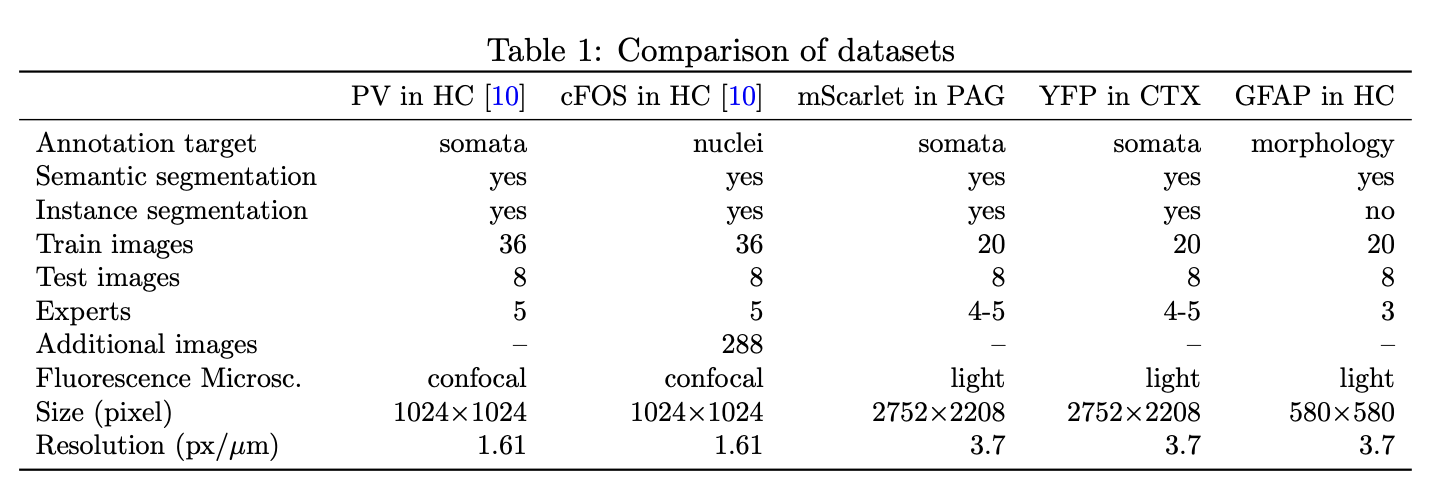

### Own Data

To use your own data sets, make sure that the folder structure is a described in the graphics below and adjust the `DATA_PATH` variable. You can either reference a folder from your personal google drive, give the url to a publicly available `.zip` file or reference a local folder if you run the notebook locally. The folder structure in the directory should be like the one shown below.


* /`YOUR_DATASET_NAME`
    *   /`train`
        * /`images`
        * /`masks_STAPLE`

    *   /`test`(only necessary when testing) 
        * /`images`
        * /`masks_STAPLE`




#### Google Drive & local
To use your own data from the Google Drive, or your machine if you run the notebook locally, change the `DATA_PATH` variable to the correct directory.
 


In [ ]:
if DATASOURCE == 'Own Directory':
  #specify if the path of your directory
  DATA_PATH = Path('/path/to/your/directory')
  DATASET = 'your_dataset_name'



#### .zip file

To use the data from a publicly avaialbe zip file, specify the url alongside the name of the dataset folder in the zip file.

In [ ]:
if DATASOURCE == 'ZIP File':
  
  #specify url of the .zip file and dataset name
  DATASET = 'your_dataset_name'
  file_name = 'your_zipfile_name.zip'


  from google.colab import files
  from zipfile import ZipFile
  import os
  from pathlib import Path

  # define extraction directory and check for existence
  
  DATA_PATH = Path('/content/data')
  if not os.path.isdir(DATA_PATH):
      os.makedirs('/content/data')

  upload = files.upload()

  zip = ZipFile('/content/'+file_name)
  zip.extractall(path=DATA_PATH)
  

### Data preprocessing

- Initialize `EnsembleLearner`
- Plot images and masks to show if they are correctly loaded

Found 11 images in "images" and 11 masks in "masks".
Computing Stats...


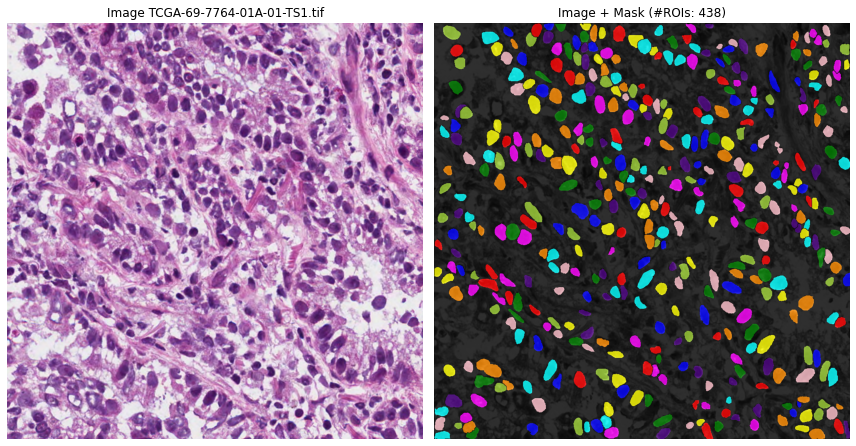

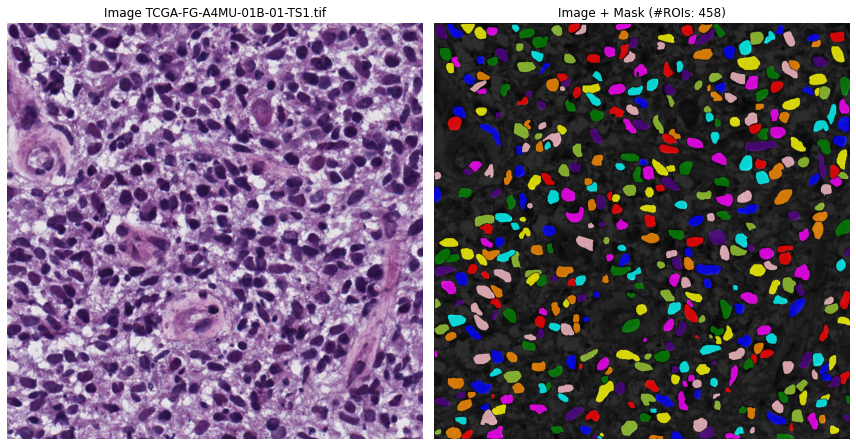

In [ ]:
train_data_path = DATA_PATH/DATASET/'train'
ensemble_path = MODEL_PATH/DATASET

el = EnsembleLearner(image_dir='images', 
                     mask_dir='masks', 
                     config=cfg, 
                     path=train_data_path, 
                     ensemble_path=ensemble_path)

el.ds.show_data(max_n=2, overlay=True)

## Train models

- Train model ensemble with 5 models
  - 2500 iterations for each model
- You can skip this step use the trained models from our paper (see next section).

In [ ]:
n_iter = 2500
el.fit_ensemble(n_iter)

## Prediction on test set

We save
- Semantic segmentation masks (.png)
- Instance segmentation masks (.tif) using the cellpose flow representations
- Foreground uncertainty scores *U*

To ensure reproducibilty we will use the trained models from our paper!

In [ ]:
test_data_path = DATA_PATH/DATASET/'test'
ensemble_trained_path = TRAINED_MODEL_PATH/DATASET/f'{SEED+1}'
prediction_path = OUTPUT_PATH/DATASET

el_pred = EnsembleLearner('images',
                          path=test_data_path, 
                          config=cfg, 
                          ensemble_path=ensemble_trained_path) 

# Predict and save semantic segmentation masks
el_pred.get_ensemble_results(el_pred.files, 
                             use_tta=True, 
                             export_dir=prediction_path/'masks')
# Save uncertainty scores
df_unc = el_pred.df_ens[['file', 'ensemble', 'n_models', 'uncertainty_score']]
df_unc.to_csv(prediction_path/'uncertainty_scores.csv', index=False)

# Show results scores
el_pred.show_ensemble_results()

In [ ]:
# Predict and save instance segmentation masks
el_pred.get_cellpose_results(export_dir=prediction_path/'instance_masks')
el_pred.show_cellpose_results()